# EEG Feature Extraction


## Importing all required libraries


In [1]:
import numpy as np
import pandas as pd
import os
import scipy.io

import matplotlib.pyplot as plt
from scipy import signal

## Importing data

Open data (in Matlab format)

In [2]:
data_root = '../input/eeg-data-for-mental-attention-state-detection/eeg data/EEG Data/'

files = os.listdir(data_root)

mat = scipy.io.loadmat(data_root + files[1])

mat['o']['sampFreq'][0][0][0][0]

data = mat['o']['data'][0, 0]
FS = mat['o']['sampFreq'][0][0][0][0]

data


array([[47.,  0.,  0., ...,  0.,  0.,  0.],
       [48.,  0.,  0., ...,  0.,  0.,  0.],
       [49.,  0.,  0., ...,  0.,  0.,  0.],
       ...,
       [36.,  0.,  0., ...,  0.,  0.,  0.],
       [37.,  0.,  0., ...,  0.,  0.,  0.],
       [38.,  0.,  0., ...,  0.,  0.,  0.]])

Define channel names following the descripiton of the data set:

4-'EDAF3' 5-'EDF7'
6-'EDF3' 7-'EDFC5'
8-'EDT7' 9-'EDP7'
10-'EDO1' 11-'EDO2'
12-'EDP8' 13-'EDT8'
14-'EDFC6' 15-'EDF4'
16-'EDF8' 17-'EDAF4'

In [3]:
channel_indices = np.array(range(3, 17))
channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']
channel_map = dict(zip(channel_names, channel_indices))

In [4]:
df = pd.DataFrame.from_dict(data)

Plot a single channel

Text(0, 0.5, 'EEG channel AF3')

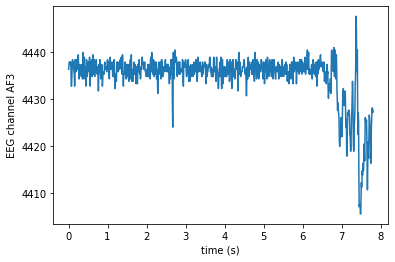

In [5]:
i_ch = 0
time = np.arange(1000) / FS
channel = data[:1000, channel_indices[i_ch]]
plt.plot(time, channel)
plt.xlabel('time (s)')
plt.ylabel(f'EEG channel {channel_names[i_ch]}')

## Extract features

Define states (according to the comments on the Data source).

The states seem to be defined arbitrarily as 10 min adjacent periods.

- 1st 10 minutes of data(t=0 min to t=10 min) is for "focussed" state
- 2nd 10 minutes of data(t=10 min to t=20 min) is for "unfocussed" state
- Remaining data(t=20 min to onwards) is for "Drowsed" state

In [6]:
states = {
 'focused': data[:FS * 10 * 60, :],
  'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
  'drowsy': data[FS * 30 * 60:, :],
}

Define frequency bands

In [7]:
bands = {'alpha': (8, 13), 'delta': (0.5, 4), 'beta': (13, 30), 'gamma': (30, np.inf)}



In [8]:
def get_data(filename):
    mat = scipy.io.loadmat(os.path.join(data_root, filename))
    data = mat['o']['data'][0, 0]
    FS = mat['o']['sampFreq'][0][0][0][0]

    states = {
     'focused': data[:FS * 10 * 60, :],
      'unfocused': data[FS * 10 * 60:FS * 20 * 60, :],
      'drowsy': data[FS * 30 * 60:, :],
    }
    return states

In [9]:
def get_powers(channel, FS=128):
    channel = channel - channel.mean()
    freq, psd = signal.periodogram(channel, fs=FS, nfft=256)

    powers = {}
    for band_name, band_limits in bands.items():
        low, high = band_limits
        powers[band_name] = psd[(freq >= low) & (freq < high)].mean()
    return powers

Select subjects

In [10]:
subjects = [5, 10, 20, 25, 33]

Extract EEG features -> mean powers in delta, alpha, beta, gamma frequency bands

In [11]:

rows_list = []
for subject_idx in subjects:
    states = get_data(f"eeg_record{subject_idx}.mat")
    for ch_name, ch_idx in channel_map.items():
        for state, eeg in states.items():
            powers = get_powers(eeg[:, ch_idx])
            powers['state'] = state
            powers['channel'] = ch_name
            powers['subject'] = f"subject_{subject_idx}"
            rows_list.append(powers)

In [12]:
df = pd.DataFrame.from_dict(rows_list)

## Explore and export data

In [13]:
df.head()

,alpha,delta,beta,gamma,state,channel,subject
0,0.109188,0.121637,0.179848,0.041091,focused,AF3,subject_5
1,0.083879,0.078891,0.074366,0.038357,unfocused,AF3,subject_5
2,0.035458,0.109983,0.039020,0.016242,drowsy,AF3,subject_5
3,1.927219,36.255531,0.892434,0.213194,focused,F7,subject_5
4,1.758539,36.506171,0.590528,0.163570,unfocused,F7,subject_5


In [14]:
df.describe()

,alpha,delta,beta,gamma
count,210.000000,210.000000,210.000000,210.000000
mean,3.893512,74.534303,0.639226,0.115020
std,9.307750,262.369517,0.860707,0.182259
min,0.000000,0.000000,0.000000,0.000000
25%,0.072074,0.129839,0.058051,0.026212
50%,1.274391,5.959509,0.356482,0.076365
75%,3.644501,48.477687,0.956902,0.150123
max,71.833644,2933.818633,7.587283,2.111892


Save the features to CSV file

In [15]:
df.to_csv("eeg_powers.csv")